## **Fichier dédié à l'établissement du modèle de régression linéaire**

Ligne de commande pour lancer le notebook depuis le terminal. Soit à coupler avec nohup ou une session tmux pour le laisser tourner en arrière plan
```bash
jupyter nbconvert --to notebook --execute --inplace regression_MLP.ipynb
```

### **Importation des modules**

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold
from scipy.stats import pearsonr
import qsar_utils as qu
import pickle
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

### **Importation des données**

In [2]:
df_norm = pd.read_csv("data/qsar_fish_toxicity_norm.csv")
data = df_norm.drop(columns=["LC50"])
LC50 = df_norm["LC50"]

### **Mise au point du modèle**

Le but du modèle de régression basé sur des réseaux neuronaux et d'observer si nous arrivons à obtenir de meilleur résultats qu'avec la méthode de RandomForest qui est souvent l'une des plus performantes dans le contexte des modèles QSAR.

**Hyperparamètres à évaluer** :
- Nombre total de neurones
- Nombre de couches cachées
- Courbe d'apprentissage
- Type d'activation
- Nombre d'itérations pour la convergence

### Modèle simple : Première approche

In [3]:
def LOO_LC50(df : pd.DataFrame, df_LC50 : pd.DataFrame) -> tuple[list[float], float]:
    """
    Cette fonction permet d'effectuer un Leave one Out sur des données pandas et de l'appliquer à un perceptron multicouche pour
    prédire la valeur de la LC50 d'une molécule
    df : tableau pandas avec les données
    df_LC50 : tableau pandas avec les valeurs de la LC50
    """
    loo = LeaveOneOut() # initialisation du LeaveOneOut
    predicted_LC50 = list()
    model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=0, verbose = True)
    cpt = 0
    tot = len(df)
    for train_index, test_index in loo.split(df): # parcours des index sélectionnés par le leave one out
        model.fit(df.iloc[train_index], df_LC50.iloc[train_index])
        predict = model.predict(df.iloc[test_index])
        predicted_LC50.append(predict[0])
        print(f"{cpt}/{tot}", end="\r") # affiche la progression sans surcharger la console
        cpt += 1
    print(f"{cpt}/{tot}") # reset de l'affichage
    corr_coef, _ = pearsonr(df_LC50, predicted_LC50) # calcul du coefficients de corrélation
    return predicted_LC50, corr_coef

In [ ]:
predicted_LC50, corr_coef = LOO_LC50(data, LC50)
with open("data/models/predicted_LC50_MLP_basic_100_100.pkl", "wb") as f:
    pickle.dump(predicted_LC50, f)

/home/be203133/.conda/envs/projet_ia/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


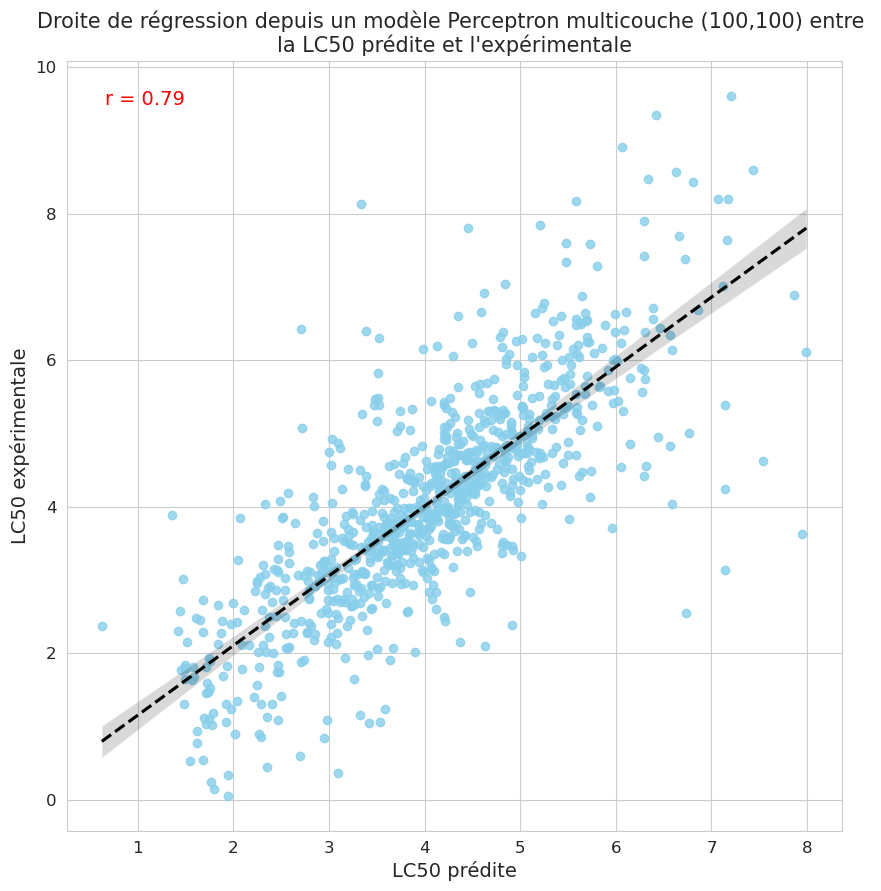

In [7]:
qu.scatter_QSAR(x_data = predicted_LC50, 
                y_data = LC50, 
                model_type = "Perceptron multicouche (100,100)",  
                corr_coef = corr_coef)

### Définition du domaine d'applicabilité (AD)

#### Mise au point des données

Le choix est d'enlever la LC50 pour ne pas biaiser la création de l'ACP et la validation des données de test

In [8]:
train_data, test_data = train_test_split(df_norm, test_size=0.2, random_state=0)
train_data_LC50 = train_data["LC50"]
test_data_LC50 = test_data["LC50"]
train_data = train_data.drop(columns=["LC50"])
test_data = test_data.drop(columns=["LC50"])

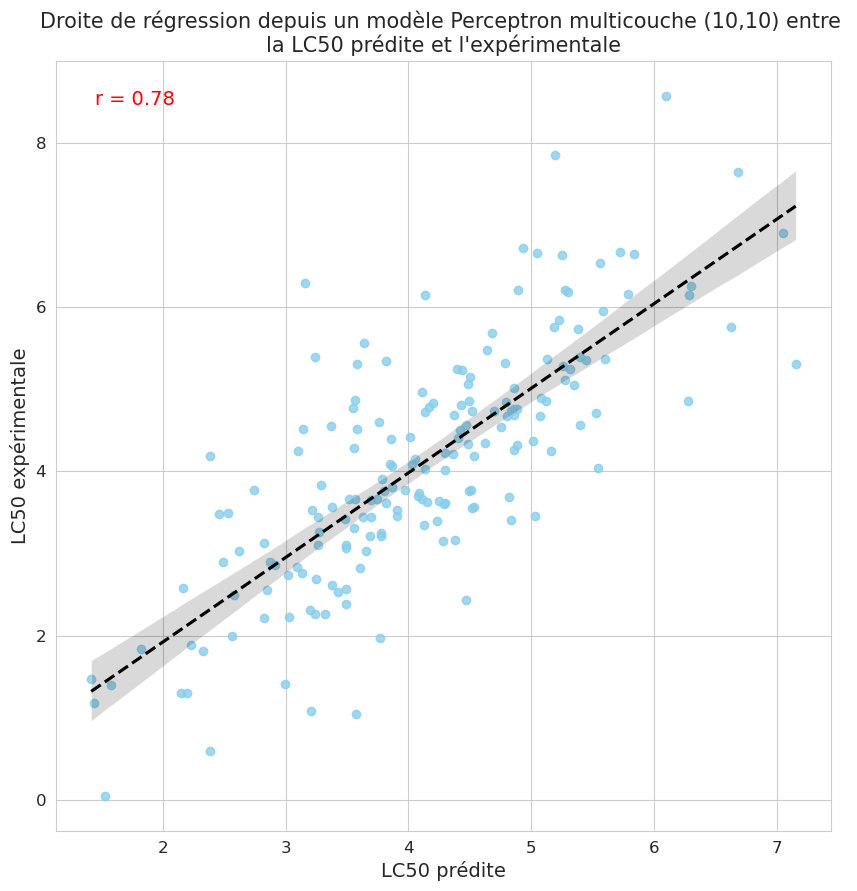

In [9]:
mlp = MLPRegressor(hidden_layer_sizes=(10, 10),
                        activation='relu',
                        solver='adam',
                        random_state=0,
                        max_iter=1000)

mlp.fit(train_data, train_data_LC50)
predicted_LC50 = mlp.predict(test_data)
corr_coef, _ = pearsonr(test_data_LC50, predicted_LC50)
qu.scatter_QSAR(x_data = predicted_LC50, 
                y_data = test_data_LC50, 
                model_type = "Perceptron multicouche (10,10)",  
                corr_coef = corr_coef)

#### Mise au point de l'ACP pour la définition du domaine d'application

In [12]:
pca = PCA(n_components=3)
data_train_pca = pca.fit_transform(train_data)
data_test_pca = pca.transform(test_data)

# Variance expliquée par composante
variance_expliquee = pca.explained_variance_ratio_
print("Variance expliquée par composante :", variance_expliquee)
print("Variance expliquée cumulée :", variance_expliquee.cumsum())

Variance expliquée par composante : [0.65497285 0.25594809 0.03844262]
Variance expliquée cumulée : [0.65497285 0.91092093 0.94936356]


On est à environ 95% d evariance expliquée avec les 3 premières CP donc on va se baser dessus pour le domaine d'applicabilité

#### Déinition des bornes du domaine

In [13]:
def in_bounding_box(sample_pca : np.ndarray, pca_min : float, pca_max : float) -> bool:
    """
    Fonction pour décider si un échantillon est dans une boîte bornée par des valeurs min et max de ses composantes PCA
    sample_pca : vecteur des composantes [comp1, comp2, ...]
    pca_min, pca_max : bornes min et max par composante (shape = [n_components])
    """
    return np.all(sample_pca >= pca_min) and np.all(sample_pca <= pca_max)

In [14]:
pca_min = np.min(data_train_pca, axis=0)
pca_max = np.max(data_train_pca, axis=0)

#### Sélection des données de tests comprises dans l'AD 
C'est le moyen le plus rapide mais aussi le plus grossier pour sélectionner les données

In [15]:
in_AD_bounding = []
for row in data_test_pca:
    in_AD_bounding.append(in_bounding_box(row, pca_min, pca_max))

in_AD_bounding = np.array(in_AD_bounding)
print("Nombre de molécules DANS le bounding box :", in_AD_bounding.sum())
print("Nombre de molécules HORS bounding box :", (~in_AD_bounding).sum())

Nombre de molécules DANS le bounding box : 178
Nombre de molécules HORS bounding box : 4


#### Vérification du voisinage

On se base sur le nombre de voisins utilisés par l'article, donc k = 6

In [ ]:
k = 6
knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
# knn.fit(data_train_pca)
# # Pour calculer la distance de chaque point de test à ses k plus proches voisins
# distances, indices = knn.kneighbors(data_test_pca)
# # distances est un tableau de shape (n_samples_test, k)
# # On peut calculer la moyenne de distance pour chaque échantillon
# mean_distances = distances.mean(axis=1)

In [ ]:
thresholds = np.linspace(0, 0.6, 100)
q2_per_threshold = []
pct_out_of_AD = []
cv = KFold(n_splits=5, shuffle=True, random_state=1) # Cross-validation
##############################################################
# 4) Boucle sur les seuils pour calculer Q² "dans l'AD" à chaque seuil
##############################################################
for thresh in thresholds:
    # Pour accumuler SSE et SST sur TOUTES les molécules "dans l'AD"
    sse_global = 0.0
    sst_global = 0.0
    
    # Pour compter combien de molécules "hors AD" sur l'ensemble des folds
    nb_out_AD = 0
    nb_total = 0
    print(f"Seuil : {thresh:.3f}", end = "\r")
    # On boucle sur les folds
    pca = PCA(n_components=3)

    for train_idx, test_idx in cv.split(df_norm):
        mlp = MLPRegressor(hidden_layer_sizes=(10, 10),
                        activation='relu',
                        solver='adam',
                        random_state=0,
                        max_iter=1000)
        X_train, X_test = df_norm.iloc[train_idx], df_norm.iloc[test_idx]
        y_train, y_test = LC50.iloc[train_idx], LC50.iloc[test_idx]
        
        X_train = X_train.drop(columns=["LC50"])
        X_test = X_test.drop(columns=["LC50"])

        
        # Entraînement du MLP sur ce fold
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        
        # Définition de l'AD sur la base du train set
        knn.fit(X_train)  # On "entraîne" le k-NN sur le train set
        
        # On calcule les distances du test set à leurs k plus proches voisins du train
        dist, _ = knn.kneighbors(X_test)  # dist.shape = (len(test_idx), k)
        
        # moyenne des distances aux k plus proches voisins
        mean_dist = dist.mean(axis=1)
        
        # on vérifie ceux qui sont "dans l'AD"
        # -> ici, dans AD si mean_dist < thresh
        in_AD_mask = (mean_dist < thresh)
        
        # Comptabiliser
        nb_out_AD += np.sum(~in_AD_mask)  # ceux hors AD
        nb_total  += len(in_AD_mask)
        
        # Pour calculer le Q², on ne garde que ceux "dans l'AD"
        y_test_in  = y_test[in_AD_mask]
        y_pred_in = y_pred[in_AD_mask]
        
        if len(y_test_in) > 0:
            # SSE
            sse_fold = np.sum((y_pred_in - y_test_in)**2)
            # SST
            sst_fold = np.sum((y_test_in - np.mean(y_test_in))**2)
        else:
            # s'il n'y a aucune molécule dans l'AD (très strict), on peut ignorer ou mettre 0
            sse_fold = 0.0
            sst_fold = 0.0
        
        sse_global += sse_fold
        sst_global += sst_fold
    
    # Après tous les folds, on calcule le Q² global (pour ce seuil)
    if sst_global == 0:
        q2_current = 0.0
    else:
        q2_current = 1 - sse_global / sst_global
    
    # Pourcentage moyen de molécules hors AD
    pct_out = nb_out_AD / nb_total
    
    q2_per_threshold.append(q2_current)
    pct_out_of_AD.append(pct_out)
print(f"Seuil : {thresh:.3f}")

Seuil : 0.000
Seuil : 0.006
Seuil : 0.012
Seuil : 0.018
Seuil : 0.024
Seuil : 0.030
Seuil : 0.036
Seuil : 0.042
Seuil : 0.048
Seuil : 0.055
Seuil : 0.061
Seuil : 0.067
Seuil : 0.073
Seuil : 0.079
Seuil : 0.085
Seuil : 0.091
Seuil : 0.097
Seuil : 0.103
Seuil : 0.109
Seuil : 0.115
Seuil : 0.121
Seuil : 0.127
Seuil : 0.133
Seuil : 0.139
Seuil : 0.145
Seuil : 0.152
Seuil : 0.158
Seuil : 0.164
Seuil : 0.170
Seuil : 0.176
Seuil : 0.182
Seuil : 0.188
Seuil : 0.194
Seuil : 0.200
Seuil : 0.206
Seuil : 0.212
Seuil : 0.218
Seuil : 0.224
Seuil : 0.230
Seuil : 0.236
Seuil : 0.242
Seuil : 0.248
Seuil : 0.255
Seuil : 0.261
Seuil : 0.267
Seuil : 0.273
Seuil : 0.279
Seuil : 0.285
Seuil : 0.291
Seuil : 0.297
Seuil : 0.303
Seuil : 0.309
Seuil : 0.315
Seuil : 0.321
Seuil : 0.327
Seuil : 0.333
Seuil : 0.339
Seuil : 0.345
Seuil : 0.352
Seuil : 0.358
Seuil : 0.364
Seuil : 0.370
Seuil : 0.376
Seuil : 0.382
Seuil : 0.388
Seuil : 0.394
Seuil : 0.400
Seuil : 0.406
Seuil : 0.412
Seuil : 0.418
Seuil : 0.424
Seuil 

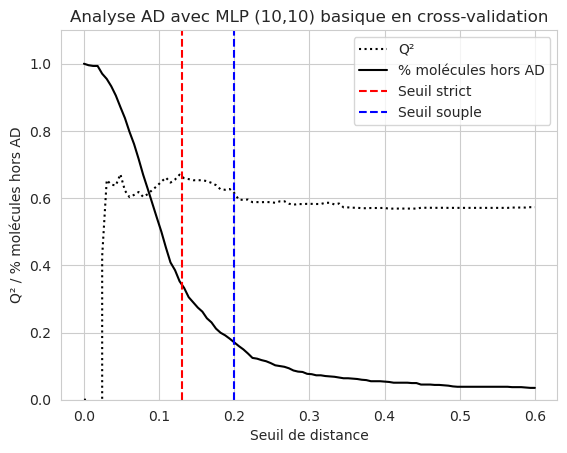

In [ ]:
qu.AD_graph(thresholds, q2_per_threshold, pct_out_of_AD, 0.13, 0.2, "Analyse AD avec MLP (10,10) basique en cross-validation")

On peut voir que le % de molécules excluses du modèle par rapport aux 6 voisins les plus proches diminue au fil de l'augmentation du seuil. Les performances du modèles Q^2 admet un maximim entre 0.1 et 0.2 de seuil. Le seuil strict permettrait d'avoir les meilleures performances et le doux permettrait d'en avoir de moins bonnes mais ils correspondraient à plus de molécule.

On peut donner l'opportunité d'utiliser le seuil strict, doux ou alors le désactiver complétement

### Optimisation des hyperparamètres

##### Recherche de la meilleure réprésentation avec la structure neuronale